# Keras + MNIST

### Celem jest rozpoznanie ręcznie napisanej cyfry.

W tym zadaniu poznasz bibliotekę [Keras](https://bit.ly/3sOvgUf), która bardzo ułatwia życie jeśli chodzi o budowanie sieci neuronowych.

In [5]:
import numpy as np
np.random.seed(0)

#Tensorflow
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

from keras.models import model_from_json

#Keras
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras import backend as K
from keras.utils import np_utils

from keras.models import model_from_json

import matplotlib.pyplot as plt
%matplotlib inline

## Wczytujemy dane

In [6]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(X_train.shape, X_test.shape)

(60000, 28, 28) (10000, 28, 28)


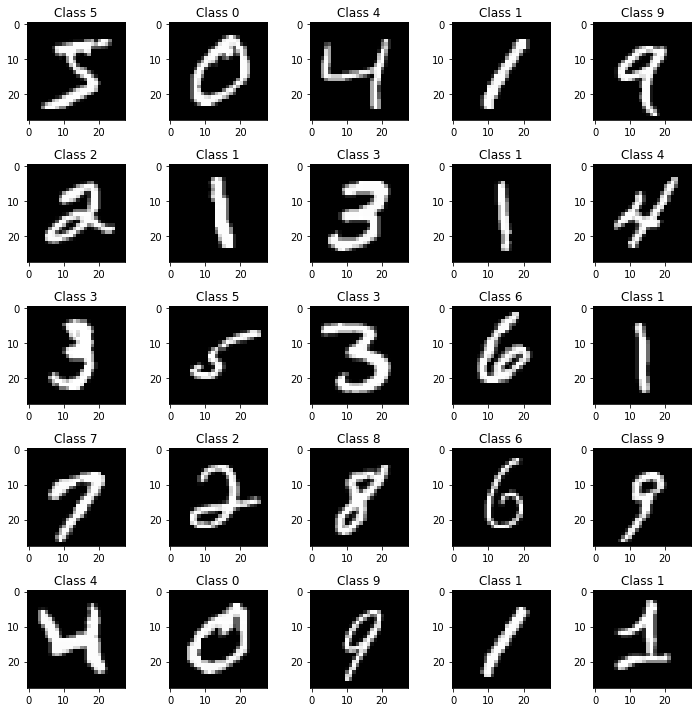

In [7]:
fig = plt.figure(figsize=(10, 10))
for idx in range(25):
    plt.subplot(5,5,idx+1)
    plt.imshow(X_train[idx], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[idx]))
    
plt.tight_layout()

## Przygotowujemy dane

Przed trenowaniem modelu (sieci neuronowej) musimy wykonać trzy kroki:
1. Spłaszczyć dane.
2. Znormalizować wartości.
3. Przygotować macierz wyjściową dla odpowiedzi.

### Spłaszczyć dane
Dlaczego to robimy?

Pamiętasz, jak wygląda warstwa wyjściowa sieci neuronowej? To jest zbiór neuronów. Każda wartość piksela w zdjęciu to wartość, którą należy podać do neuronu. Ale mamy problem (albo wyzwanie) - nasze zdjęcie jest kwadratowe (lub prostokątne), a sieć oczekuje "płaskiej" struktury.

Wyjaśnię to poprzez analogię. Jeśli popatrzysz na tłum ludzi z góry na jakimś placu, to może on przypominać kształtem kwadrat lub prostokąt. Wyobraź sobie, że ten tłum ludzi chce wejść do budynku. Załóżmy, że każdy człowiek musi wejść przez "swoje" drzwi (załóżmy, że mamy wystarczającą liczbę drzwi dla każdego). Teraz wyobraź sobie na chwilę, jak tłum ludzi zaczyna "spłaszczać się", bo każdy podchodzi do swoich drzwi. Ostatecznie przypomina to bardziej długą "linię" ludzi, niż tłum w postaci kwadratu czy prostokąta.

Podobnie jest tutaj - chcemy w pewnym sensie pokroić nasze zdjęcie na wiersze (gdzie jeden wiersz ma wysokość 1 piksela) i następnie to skleić. W rezultacie dostaniemy długą wstążkę wartości (matematycy lubią nazywać to wektorem).

### Znormalizować wartości
Sieć neuronowa oczekuję na wartości od 0 do 1. Pomyśl przez chwilę dlaczego akurat tak? Albo pomyśl inaczej. Jeśli masz jedną cechę, której wartość to ok. 10M i drugą cechę, która ma wartość jedynie 10 (czyli milion razy mniej), to jaka powinna być waga (liczba łącząca neurony), żeby model zaczął się trenować?

Pomyśl dalej, co może się stać z siecią (jak taka waga wpłynie na sąsiednie neurony), jeśli wartość wagi będzie również duża, np. milion?

Podam Ci analogię. Mimo tego, że ludzie z przyzwyczajenia wyglądają na poważnych i czasem zbyt "wolnych", to każdy ma swojego szefa (teraz niekoniecznie chodzi mi o życie zawodowe, ale też o to). Jak myślisz, kiedy będzie łatwiej "dogadać" się? Wtedy kiedy wszyscy są na tym samym poziomie, czy gdy ktoś jest wyżej od Ciebie o kilka czy kilkanaście szczebli? W pewnym sensie normalizacja, to przekazanie informacji do nas przez naszych szefów. Wtedy nie jest ważne, jak wysoko lub nisko jesteś, dla Ciebie komunikat będzie zrozumiały :).

### Odpowiedzi jako macierz
Na początku mamy odpowiedzi jako wektor. Na przykład dla cyfr, ten wektor przyjmuje wartości od 0 do 9 (czyli na obrazku x jest 0, na y jest 8 itd). Sieć jednak nie zwraca jednoznacznej odpowiedzi, a prawdopodobieństwa dla każdej cyfry (obrazka). Innymi słowy, model dla danego obrazka cyfry zwróci dziesięć prawdopodobieństw (po jednym dla każdej możliwej cyfry). Większość z tych prawdopodobieństw będzie zapewne bliska zero, natomiast jedno czy kilka będą na tle innych znacznie się wyróżniać.

Poniżej przykład jak jeden obrazek na wejściu wygeneruje 10 liczb na wyjściu.
 
![](../images/mnist_intput_output.png)

*Swoją drogą* możesz o tym myśleć tak, że robimy tutaj one-hot encoding dla zmiennej docelowej. Czyli tworzymy **n** nowych kolumn, gdzie **n** to jest ilość unikalnych wartości w zmiennej docelowej.

Tyle teorii,  teraz pora przejść do kodu :).

In [8]:
#najpierw spłaszczamy
if len(X_train.shape) == 3:
    num_pixels = X_train.shape[1] * X_train.shape[2]
    X_train = X_train.reshape(X_train.shape[0], num_pixels).astype("float32")
    X_test = X_test.reshape(X_test.shape[0], num_pixels).astype("float32")

print(X_train.shape, X_test.shape)

#skalujemy od 0 do 1
if np.max(X_train) > 1: X_train /= 255
if np.max(X_test) > 1: X_test /= 255

#one-hot encoding dla zmiennej docelowej - Tensorflow
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

#one-hot encoding dla zmiennej docelowej - Keras
#y_train = keras.utils.np_utils.to_categorical(y_train)
#y_test = keras.utils.np_utils.to_categorical(y_test)

num_classes = y_test.shape[1]

(60000, 784) (10000, 784)


## Architektura ([MLP](https://bit.ly/3aB6qB0))
Zbudujemy teraz bardzo prostą sieć, na którą będą się składać 3 warstwy:
1. Warstwa wejściowa.
2. Warstwa ukryta.
3. Warstwa wyjściowa.

### Warstwa wejściowa (ang. *input layer*)
Zwróć uwagę, że liczba neuronów w warstwie wejściowej wprost zależy od danych wejściowych. Na przykład dla MNIST rozmiar zdjęcia wynosi: **28x28**. Po spłaszczeniu będzie to `28*28=784`.

Dlatego warstwa wejściowa będzie zawierać dokładnie 784 neurony. Mało tego, jeśli spróbujesz podać zdjęcia innego rozmiaru, np. **30x28** to sieć “rzuci” wyjątek. Dzieje się tak, ponieważ ta sieć oczekuje tylko i wyłącznie na zdjęcia o rozmiarze **28x28** (to jest ważne, żeby rozumieć to ograniczenie na początku).

### (Pierwsza) warstwa ukryta (ang. *hidden layer*)
Rozmiar (liczba neuronów) warstwy ukrytej jest zmienny. Najczęściej dobiera się go w taki sposób, żeby liczba neuronów była w miarę podobna do tej w warstwie wejściowej (zwykle trochę mniej). 

Istnieje również taka praktyka, że stosujemy liczby binarne takie jak: 128, 256, 512... Tak naprawdę, to nie jest wymóg. Natomiast polecam stopniować to w ten sposób, wtedy życie będzie łatwiejsze i będzie pojawiać się mniej pytań o to, ile powinno być neuronów (bo liczba opcji nagle maleje do kilku) :)

### Warstwa wyjściowa (ang. *output layer*)
Będzie zawierać tyle neuronów, ile mamy (unikalnych) klas. W naszym przypadku 10.


## Keras
Umożliwia w bardzo prosty sposób budowanie architektury sieci neuronowych. Dlatego używa się `Sequential` i następnie w formie listy przekazujemy kolejne warstwy.

**Zwróć uwagę**, że definicja warstwy wejściowej (ang. *input layer*) jest trochę nudna. Bo informujesz tylko i wyłącznie o liczbie neuronów (nie masz żadnych funkcji aktywacji, inicjalizacji wag itd). Dlatego Keras próbuje jeszcze bardziej to uprościć i umożliwia w **pierwszej** (podkreślam słowo pierwszej) warstwie ukrytej poinformować o rozmiarze warstwy wejściowej, używając paramateru `input_dim`. Ten parametr oczekuje na liczbę (w naszym przypadku to 784).

Popatrz na kod:
```
model = Sequential([
    Dense(512, input_dim=num_pixels, activation='relu'),
    Dense(num_classes, kernel_initializer='normal', activation='softmax')
])
```

Jak widzisz, w sekwencji mamy jawnie podane dwie warstwy. Natomiast nasza sieć składa się z trzech warstw (wejściowa, ukryta i wyjściowa). Warstwa wejściowa (input layer) będzie wygenerowana automatycznie przez Keras, ponieważ w warstwie ukrytej podaliśmy: `input_dim=num_pixels`, gdzie `num_pixels = X_train.shape[1] * X_train.shape[2]` czyli `num_pixels = 28 * 28`.

Na samym końcu budujemy sieć, wywołując `.compile()`: 
```
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
```

- **loss** - to funkcja kosztu (albo wewnętrzna metryka sukcesu). Tę funkcję model będzie chciał minimalizować.
- **metrics** - to (zewnętrzna) metryka sukcesu. To jest metryka tylko dla nas, jednak model jej nie optymalizuje w żaden sposób.
- **optimizer** - to optymalizator, jest ich sporo... Na razie użyj któregokolwiek (bo problemy, które rozwiązujemy teraz są proste).

In [9]:
model = Sequential([
    Dense(512, input_dim=num_pixels, activation='relu'),
    Dense(num_classes, activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


2022-10-17 17:02:44.539634: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Trenowanie

Model oczekuje na:
- **X** i **y** (na ten moment już zakładamy, że temat walidacji jest oczywisty, więc dlatego będzie **X_train** i **y_train**)
- **batch_size**, **epochs**
- **validation_data** - potrzebne do śledzenia krzywej uczenia się.

### `batch_size` i `epochs`
Wymaga dodatkowego wyjaśnienia. Teraz trochę upraszczając, żeby zrozumieć, o co chodzi na poziomie intuicji.

Trenowanie modelu oznacza dobór parametrów - wag.

##### W jaki sposób uczy się sieć?
1. Stan początkowy, wtedy kiedy znamy tylko wartości neuronów wejściowych (w przypadku MNIST to są wartości pikseli na zdjęciu) i architekturę sieci (bo sami zdefiniowaliśmy je przed chwilą).
2. Pierwsze wagi są inicjalizowane w sposób losowy (swoją drogą to jest ważne co to oznacza w praktyce, ale na razie niech to będzie po prostu w sposób losowy).
3. Następnie zaczynamy przechodzić od lewej (warstwy wejścia) do prawej (warstwy wyjścia).
4. Proces przejścia od lewej do prawej nazywa się forward propagation.
5. Następnie, gdy mamy wynik, porównujemy go z wynikiem prawidłowym (odpowiedzią).
6. Wykorzystując metrykę sukcesu wyliczamy, jak duży jest błąd.
7. Następnie próbujemy zmniejszyć błąd, próbując naprawiać wagi i idąc z powrotem od prawej do lewej strony (ten proces nazywa się backpropagation lub backprop).

Przepuszczenie **wszystkich danych** od lewej do prawej (forward propagation) i od prawej do lewej (backprop) nazywa się “epoką”. W praktyce często dane na wejściu dzielimy na paczki (ang. batch), więc przepuszczamy dane paczkami. Przykładowo, jeśli mamy wszystkich danych 100, a rozmiar paczki (ang. batch size) ustalimy na 20, to będziemy potrzebować 5 iteracji, żeby przepuścić wszystkie dane przez sieć. Czyli 1 epoka zakończy się dopiero po przejściu 5 paczek z danymi.

Po co przepuszczamy paczkami zamiast puścić wszystko na raz i mieć problem z głowy? Jest kilka powodów. Jeden to zasoby, ale to nie jest duży problem, bo zasoby stają się coraz bardziej dostępne.

Istnieje jeszcze drugi problem - to jakość modelu. Okazuje się, że model uczy się lepiej, kiedy ma więcej iteracji tam i z powrotem. Przejście za jednym razem tam i z powrotem daje Ci jedną możliwą korektę wag na całą epokę. Jeśli masz jednak 5 iteracji, to aż 5 razy częściej będziesz modyfikować wagi w sieci.

Na poziomie analogii, możesz to zrozumieć w następujący sposób. Jak masz egzamin z wiadomości których totalnie nie znasz, ale musisz go zdać, kiedy będzie Ci łatwiej - wtedy, jak masz jedną próbę czy 5, 10 albo nawet 100?

*Swoją drogą* jeśli nadal masz wątpliwości, jaka jest różnica pomiędzy *batch_size* i *epochs*, to możesz sprawdzić to [video](https://www.youtube.com/watch?v=U4WB9p6ODjM) albo tutaj jest cała [lista](https://www.youtube.com/playlist?list=PLZbbT5o_s2xq7LwI2y8_QtvuXZedL6tQU).

In [10]:
model.fit(X_train, y_train,
          batch_size=1024, epochs=20, verbose=2,
          validation_data=(X_test, y_test))

Epoch 1/20
59/59 - 1s - loss: 0.5576 - accuracy: 0.8502 - val_loss: 0.2567 - val_accuracy: 0.9278 - 935ms/epoch - 16ms/step
Epoch 2/20
59/59 - 1s - loss: 0.2292 - accuracy: 0.9357 - val_loss: 0.1906 - val_accuracy: 0.9458 - 516ms/epoch - 9ms/step
Epoch 3/20
59/59 - 0s - loss: 0.1736 - accuracy: 0.9513 - val_loss: 0.1548 - val_accuracy: 0.9556 - 492ms/epoch - 8ms/step
Epoch 4/20
59/59 - 1s - loss: 0.1382 - accuracy: 0.9611 - val_loss: 0.1317 - val_accuracy: 0.9612 - 508ms/epoch - 9ms/step
Epoch 5/20
59/59 - 1s - loss: 0.1133 - accuracy: 0.9685 - val_loss: 0.1128 - val_accuracy: 0.9670 - 500ms/epoch - 8ms/step
Epoch 6/20
59/59 - 1s - loss: 0.0953 - accuracy: 0.9734 - val_loss: 0.1016 - val_accuracy: 0.9695 - 506ms/epoch - 9ms/step
Epoch 7/20
59/59 - 1s - loss: 0.0831 - accuracy: 0.9768 - val_loss: 0.0947 - val_accuracy: 0.9717 - 511ms/epoch - 9ms/step
Epoch 8/20
59/59 - 1s - loss: 0.0705 - accuracy: 0.9804 - val_loss: 0.0887 - val_accuracy: 0.9737 - 509ms/epoch - 9ms/step
Epoch 9/20
59/5

## Learning Curve
Jak możesz się domyślić sieci neuronowe też mają problem z przeuczeniem się. Mało tego, one potrafią się przeuczyć tak naprawdę, bo zawierają sporo parametrów (czasem to są miliony czy nawet setki milionów parametrów).

### Jak możemy walczyć z przeuczeniem się?
Są różne techniki, część z nich poznamy. Istnieją dość standardowe, takie jak więcej danych czy prostszy model (mniej neuronów, mniej warstw itd). Są również dość specyficzne, które funkcjonują tylko w sieciach neuronowych, takie jak np. *Dropout* albo *BatchNormalization*.

Ważne w tym wszystkim jest to, aby mieć narzędzia, które pomagają wykrywać przeuczenie się. Tutaj na pomoc przychodzi krzywa uczenia się.

Natomiast jeszcze przed krzywą, warto nauczyć się czytać to, co wypisuje model. Dla przykładu, jedna linia wygląda następująco:

```
Epoch 1/20
 - 2s - loss: 0.9033 - acc: 0.8032 - val_loss: 0.4195 - val_acc: 0.8934
```

Widzimy, że to jest pierwsza epoka (wszystkich będzie 20). Zajęła ona ok. 2 s. Następnie mamy dwie metryki (`loss` i `acc`), raz dla zbioru treningowego i raz dla zbioru testowego.

#### Zbiór treningowy
- **loss** (wewnętrzna metryka sukcesu): 0.9033
- **acc** (zewnętrzna metryka sukcesu, dokładność): 0.8032

#### Zbiór testowy
- **val_loss** (wewnętrzna metryka sukcesu): 0.4195
- **val_acc** (zewnętrzna metryka sukcesu, dokładność): 0.8934

Pewnie już się domyślasz, że aby uniknąć przeuczenia się, `acc` i `val_acc` muszą być blisko siebie.

## Testowanie

Przekazujemy `X_test` i `y_test` do `.evaluate()` i to zwraca nasz `score`, a dokładnie to dwie liczby. W terminologii, której używam, to wewnętrzna i zewnętrzna metryka sukcesu.

Przypomnę, że jak była tworzona architektura sieci, na końcu pojawiała się linijka kodu, która "łączy" wszystko w jedną sieć: 
```
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy']).
```

Zwróć uwagę, że tutaj jawnie podaje się `loss`, w naszym przypadku to `categorical_crossentropy` (czasem nazywane **log_loss**) i to jest wewnętrzna metryka sukcesu, która powinna posiadać pierwszą i drugą pochodną.

Natomiast `metrics=['accuracy']` to jest miejsce na definicję zewnętrznej metryki sukcesu. Możesz mieć jedną lub więcej metryk. 

In [11]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

print("MLP Error: %.2f%%" % (100-score[1]*100))

Test loss: 0.062249451875686646
Test accuracy: 0.980400025844574
MLP Error: 1.96%


## O jedną warstwę ukrytą więcej
Zwróć uwagę, że `input_dim` pojawia się tylko w pierwszej warstwie ukrytej, po to żeby poinformować o rozmiarze warstwy wejściowej, którą za nas stworzy Keras.

`model.summary()` wypisuje informację o architekturze naszej sieci. Pewnie warto spędzić chwilę, żeby nauczyć się to interpretować.


```
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
dense_12 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_13 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_14 (Dense)             (None, 10)                2570      
=================================================================
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
```
Po pierwsze widać, że mamy 3 warstwy (warstwa wejściowa będzie dodana automatycznie): dwie to warstwy ukryte i jedna wyjściowa.

### Pierwsza warstwa ukryta
Ma rozmiar 512 (czyli posiada 512 neuronów) i powinna wytrenować **401 920** parametrów (czyli wag). Skąd bierze się ta liczba? Pamiętasz, że nasza warstwa wejściowa to **784** (28 x 28). Perceptron wielowarstwowy ma połączenie każdy z każdym. Innymi słowy, pierwszy neuron łączy się z 512 neuronami warstwy ukrytej, to samo robi drugi neuron, trzeci itd. Czyli mamy 784 x 512 = **401 408**. Jeśli uważnie popatrzysz, to zauważysz, że trochę różni się **401 920** vs **401 408**, a dokładnie o **512**, ponieważ oprócz wag mamy jeszcze tak zwany "bias" dla każdego neuronu, który jest rodzajem wartości stałej.

### Druga warstwa ukryta
Wygląda podobnie. Mamy 256 neuronów (więc zmniejszamy rozmiar na wejściu w ten sposób - chcemy, żeby przejście do warstwy wyjściowej z 10 neuronami było bardziej łagodne). Widzimy, że w tym przypadku trzeba dobrać **131 328** parametrów (wag): `512 * 256 + 256 = 131 328`.

### Trzecia warstwa (warstwa wyjściowa)
Posiada 10 neuronów (jeden dla każdej cyfry, w którym będzie wartość pomiędzy 0 a 1 dla danego zdjęcia, czyli prawdopodobieństwo dla każdej cyfry).

Na końcu jest informacja o wszystkich parametrach: **Total params: 535,818** i ile z nich będzie trenowanych. Na ten moment, wszystkie parametry będą trenowane (w module 7 zobaczysz po co).

In [12]:
model = Sequential([
    Dense(512, input_dim=num_pixels, activation='relu'),
    Dense(256, activation='relu'),
    Dense(num_classes, kernel_initializer='normal', activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 512)               401920    
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dense_4 (Dense)             (None, 10)                2570      
                                                                 
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.fit(X_train, y_train,
          batch_size=1024, epochs=10, verbose=2,
          validation_data=(X_test, y_test))

Epoch 1/10
59/59 - 1s - loss: 2.3012 - accuracy: 0.0815 - val_loss: 2.2956 - val_accuracy: 0.0929 - 1s/epoch - 18ms/step
Epoch 2/10
59/59 - 1s - loss: 2.2907 - accuracy: 0.0987 - val_loss: 2.2847 - val_accuracy: 0.1126 - 713ms/epoch - 12ms/step
Epoch 3/10
59/59 - 1s - loss: 2.2800 - accuracy: 0.1185 - val_loss: 2.2736 - val_accuracy: 0.1358 - 664ms/epoch - 11ms/step
Epoch 4/10
59/59 - 1s - loss: 2.2691 - accuracy: 0.1400 - val_loss: 2.2623 - val_accuracy: 0.1616 - 693ms/epoch - 12ms/step
Epoch 5/10
59/59 - 1s - loss: 2.2580 - accuracy: 0.1642 - val_loss: 2.2508 - val_accuracy: 0.1896 - 718ms/epoch - 12ms/step
Epoch 6/10
59/59 - 1s - loss: 2.2467 - accuracy: 0.1927 - val_loss: 2.2391 - val_accuracy: 0.2198 - 714ms/epoch - 12ms/step
Epoch 7/10
59/59 - 1s - loss: 2.2352 - accuracy: 0.2225 - val_loss: 2.2273 - val_accuracy: 0.2518 - 720ms/epoch - 12ms/step
Epoch 8/10
59/59 - 1s - loss: 2.2236 - accuracy: 0.2550 - val_loss: 2.2153 - val_accuracy: 0.2868 - 723ms/epoch - 12ms/step
Epoch 9/10


In [14]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

print("MLP Error: %.2f%%" % (100-score[1]*100))

Test loss: 2.1907942295074463
Test accuracy: 0.3547999858856201
MLP Error: 64.52%


## Dodajmy <a href="https://bit.ly/3tOFzbT">Dropout</a>

Istnieją różne metody, żeby walczyć z przeuczeniem. Jedna z nich to zastosowanie **Dropout** - przyjmuje ona wartość od 0 do 1. W praktyce oznacza to usuwanie, "deaktywację" neuronów dla danej epoki. Przykład, w sytuacji gdy jest wartość 0 to wszystkie neurony działają (czyli to jest równoznacznie z tym, że dropout nie ma). Jeżeli dropout wynosi *0.6*. - oznacza to, że model wyłącza 60% losowo wybranych neuronach.

Są dwa podejścia dropout: podanie go dla całej sieci lub dla danej warstwy. W naszym przypadku (Keras) jest drugi przypadek: czyli wpływa tylko na konkretną warstwę.

Zastosujemy *Dropout* dwa razy (czyli po pierwszej i drugiej warstwie).

In [15]:
model = Sequential([
    Dense(512, input_dim=num_pixels, activation='relu'),
    Dropout(0.5), #wylącz 50% neuronów
    Dense(256, activation='relu'),
    Dropout(0.2), #wylącz 20% neuronów
    Dense(num_classes, kernel_initializer='normal', activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 10)                2570      
                                                                 
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.fit(X_train, y_train,
          batch_size=1024, epochs=10, verbose=2,
          validation_data=(X_test, y_test))

Epoch 1/10
59/59 - 1s - loss: 2.3283 - accuracy: 0.1105 - val_loss: 2.3003 - val_accuracy: 0.1245 - 1s/epoch - 22ms/step
Epoch 2/10
59/59 - 1s - loss: 2.3184 - accuracy: 0.1162 - val_loss: 2.2909 - val_accuracy: 0.1339 - 941ms/epoch - 16ms/step
Epoch 3/10
59/59 - 1s - loss: 2.3106 - accuracy: 0.1205 - val_loss: 2.2814 - val_accuracy: 0.1439 - 947ms/epoch - 16ms/step
Epoch 4/10
59/59 - 1s - loss: 2.3014 - accuracy: 0.1241 - val_loss: 2.2718 - val_accuracy: 0.1535 - 1s/epoch - 17ms/step
Epoch 5/10
59/59 - 1s - loss: 2.2911 - accuracy: 0.1304 - val_loss: 2.2621 - val_accuracy: 0.1669 - 946ms/epoch - 16ms/step
Epoch 6/10
59/59 - 1s - loss: 2.2832 - accuracy: 0.1334 - val_loss: 2.2524 - val_accuracy: 0.1818 - 1s/epoch - 18ms/step
Epoch 7/10
59/59 - 1s - loss: 2.2741 - accuracy: 0.1405 - val_loss: 2.2427 - val_accuracy: 0.1979 - 1s/epoch - 18ms/step
Epoch 8/10
59/59 - 1s - loss: 2.2659 - accuracy: 0.1478 - val_loss: 2.2329 - val_accuracy: 0.2182 - 1s/epoch - 19ms/step
Epoch 9/10
59/59 - 1s -

In [17]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

print("MLP Error: %.2f%%" % (100-score[1]*100))

Test loss: 2.213235378265381
Test accuracy: 0.26489999890327454
MLP Error: 73.51%


## Przydatne linki:


- [But what is a Neural Network?](https://bit.ly/2PhH1EM)
- [Getting started with the Keras Sequential model](https://bit.ly/3aEqt1o)
- [Your First Deep Learning Project in Python with Keras Step-By-Step](https://bit.ly/3tKjA62)
- [How To Build Multi-Layer Perceptron Neural Network Models with Keras](https://bit.ly/3gCJKUK)
-  [Hyperas - keras + hyperopt](https://bit.ly/2QsILf2)
- [An overview of gradient descent optimization algorithms](https://bit.ly/3vdZCRu)
